<h1><center>CMPE 462 - Project 2<br>Implementing an SVM Classifier<br>Due: May 18, 2020, 23:59</center></h1>

**Student ID1:** 2019700213  
**Student ID2:** 2015400003  
**Student ID3:** 2014400039

## Overview

In this project, you are going to implement SVM. For this purpose, a data set (data.mat) is given to you. You can load the mat dataset into Python using the function `loadmat` in `Scipy.io`. When you load the data, you will obtain a dictionary object, where `X` stores the data matrix and `Y` stores the labels. You can use the first 150 samples for training and the rest for testing. In this project, you will use the software package [`LIBSVM`](http://www.csie.ntu.edu.tw/~cjlin/libsvm/) to implement SVM. Note that `LIBSVM` has a [`Python interface`](https://github.com/cjlin1/libsvm/tree/master/python), so you can call the SVM functions in Python. 

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scipy numpy libsvm contextlib2 prettytable matplotlib numpy

  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13698 sha256=4923106fec196e565f4d72811347c877c96405c645bc94b15a007caa328c964f
  Stored in directory: /Users/furkan/Library/Caches/pip/wheels/8c/76/0b/eb9eb3da7e2335e3577e3f96a0ae9f74f206e26457bd1a2bc8
Successfully built prettytable


In [2]:
from scipy.io import loadmat
import numpy as np
from libsvm.svmutil import *
from contextlib2 import redirect_stdout
from prettytable import PrettyTable
from matplotlib import pyplot as plt 
import numpy as np
import math
import io

## Task 1 - 30 pts

Train a hard margin linear SVM and report both train and test classification accuracy.

In [3]:
mat_data = loadmat('data.mat')

x, y = mat_data['X'], np.squeeze(mat_data['Y'])

train_x, test_x = x[:150], x[150:]
train_y, test_y = y[:150], y[150:]

SVM_PROBLEM = svm_problem(train_y, train_x)

# Setting c to a large value here (99..9) to train hard margin SVM.
hard_svm_parameter = svm_parameter('-c 999999999')
hard_svm_model = svm_train(SVM_PROBLEM, hard_svm_parameter)

print("Train:")
train_res=svm_predict(train_y, train_x, hard_svm_model)
print("\nTest:")
test_res=svm_predict(test_y, test_x, hard_svm_model)

# Accuracy:
# print(train_res[1][0])
# print(test_res[1][0])

Train:
Accuracy = 100% (150/150) (classification)

Test:
Accuracy = 76.6667% (92/120) (classification)


## Task 2 - 40 pts

Train soft margin SVM for different values of the parameter $C$, and with different kernel functions. Systematically report your results. For instance, report the performances of different kernels for a fixed $C$, then report the performance for different $C$ values for a fixed kernel, and so on.

In [4]:
kernels = range(4)

c_vals = [10**x for x in range(-2,7)] 

results = {}
for k in kernels:
    k_res = {}
    for c in c_vals:
        soft_svm_parameter = svm_parameter('-c {} -t {}'.format(c,k))
        soft_svm_model = svm_train(SVM_PROBLEM, soft_svm_parameter)
        trap = io.StringIO()
        with redirect_stdout(trap):
            # svm_predict prints accuracy to stdout. Surpressing here.
            train_res=svm_predict(train_y, train_x, soft_svm_model)
            test_res=svm_predict(test_y, test_x, soft_svm_model)
        k_res[c] = (train_res[1][0], test_res[1][0], soft_svm_model) 
    results[k] = k_res        

In [5]:
data_points = []
for k,res in results.items():
    for c,r in res.items():
        data_points.append([k,c,round(r[0], 1),round(r[1], 1),len(r[2].get_sv_indices())])

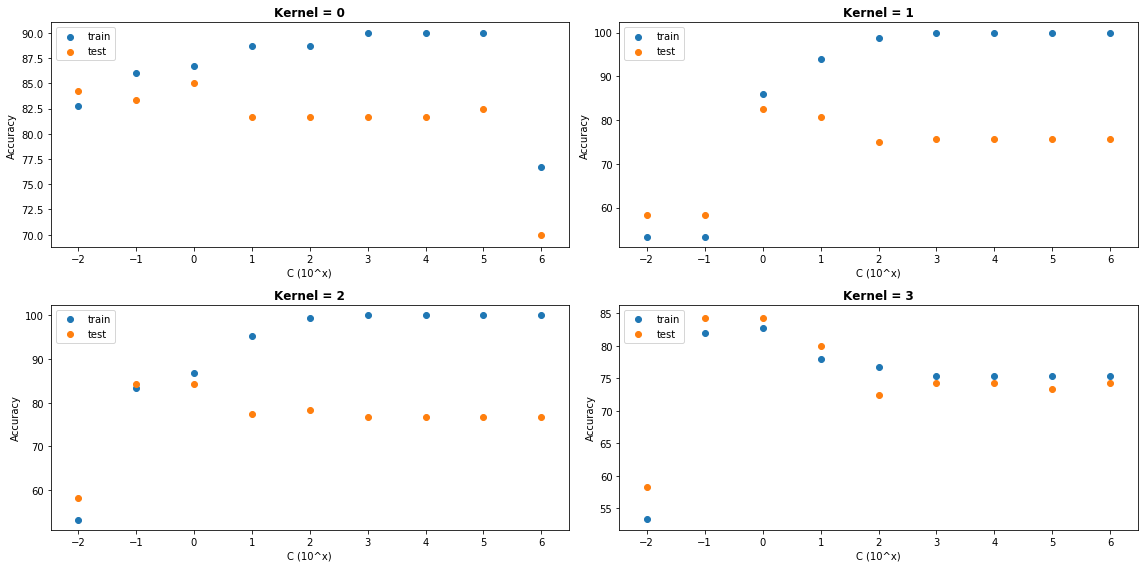

In [6]:
# Graphs grouped by kernel.
n = np.array(data_points)
plt.figure(figsize=(16,8))
for i in range(4):
    ax=plt.subplot(2, 2, i+1)
    sub_data = n[np.where(n[:,0] == i)] # i stands for the kernel.
    x = [math.log(y,10) for y in c_vals]
    y1 = sub_data[:,2] # train
    y2 = sub_data[:,3] # test
    ax.scatter(x, y1) 
    ax.scatter(x, y2) 
    ax.legend(['train', 'test'], loc='upper left')
    ax.set_xlabel('C (10^x)')
    ax.set_ylabel('Accuracy')
    ax.set_title('Kernel = {}'.format(i),fontweight="bold")
plt.tight_layout()
plt.show() 

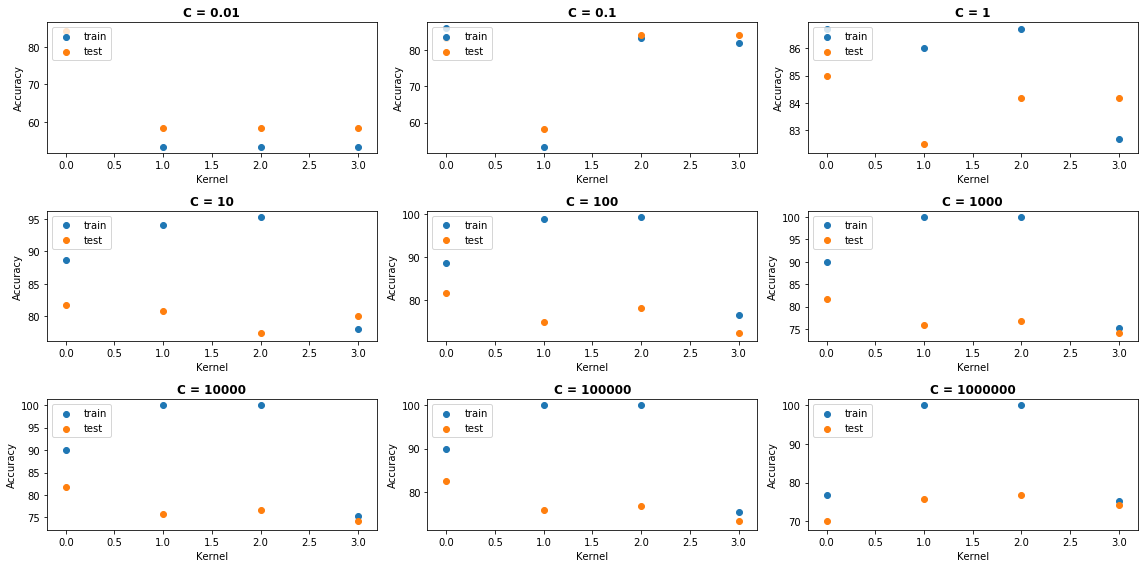

In [7]:
# Graphs grouped by C values.

plt.figure(figsize=(16,8))
for i,c in enumerate(c_vals):
    ax=plt.subplot(3, 3, i+1)
    sub_data = n[np.where(n[:,1] == c)] # c stands for C value.
    x = kernels
    y1 = sub_data[:,2] # train
    y2 = sub_data[:,3] # test
    ax.scatter(x, y1) 
    ax.scatter(x, y2) 
    ax.legend(['train', 'test'], loc='upper left')
    ax.set_xlabel('Kernel')
    ax.set_ylabel('Accuracy')
    ax.set_title('C = {}'.format(c),fontweight="bold")
plt.tight_layout()
plt.show() 

In [8]:
# This cell generates the table form of the results shown in above graphs, nothing extra.

t = PrettyTable(["Kernel", "C", "Train", "Test", "Vectors"])
t.align["C"] = "l"
for k,res in results.items():
    for c,r in res.items():
        t.add_row([k,c,round(r[0], 1),round(r[1], 1),len(r[2].get_sv_indices())])
        
print("Grouped by Kernels:")
print(t)

print("Grouped by C values:")
t.sortby = 'C'
print(t)

Grouped by Kernels:
+--------+---------+-------+------+---------+
| Kernel | C       | Train | Test | Vectors |
+--------+---------+-------+------+---------+
|   0    | 0.01    |  82.7 | 84.2 |   118   |
|   0    | 0.1     |  86.0 | 83.3 |    74   |
|   0    | 1       |  86.7 | 85.0 |    58   |
|   0    | 10      |  88.7 | 81.7 |    51   |
|   0    | 100     |  88.7 | 81.7 |    50   |
|   0    | 1000    |  90.0 | 81.7 |    49   |
|   0    | 10000   |  90.0 | 81.7 |    49   |
|   0    | 100000  |  90.0 | 82.5 |    52   |
|   0    | 1000000 |  76.7 | 70.0 |    79   |
|   1    | 0.01    |  53.3 | 58.3 |   141   |
|   1    | 0.1     |  53.3 | 58.3 |   141   |
|   1    | 1       |  86.0 | 82.5 |   118   |
|   1    | 10      |  94.0 | 80.8 |    84   |
|   1    | 100     |  98.7 | 75.0 |    74   |
|   1    | 1000    | 100.0 | 75.8 |    73   |
|   1    | 10000   | 100.0 | 75.8 |    73   |
|   1    | 100000  | 100.0 | 75.8 |    73   |
|   1    | 1000000 | 100.0 | 75.8 |    73   |
|   2    | 0.0

### Performance Report

TODO


## Task 3 - 15 pts

Please report how the number of support vectors changes as the value of $C$ increases (while all other parameters remain the same). Discuss whether your observations match the theory.

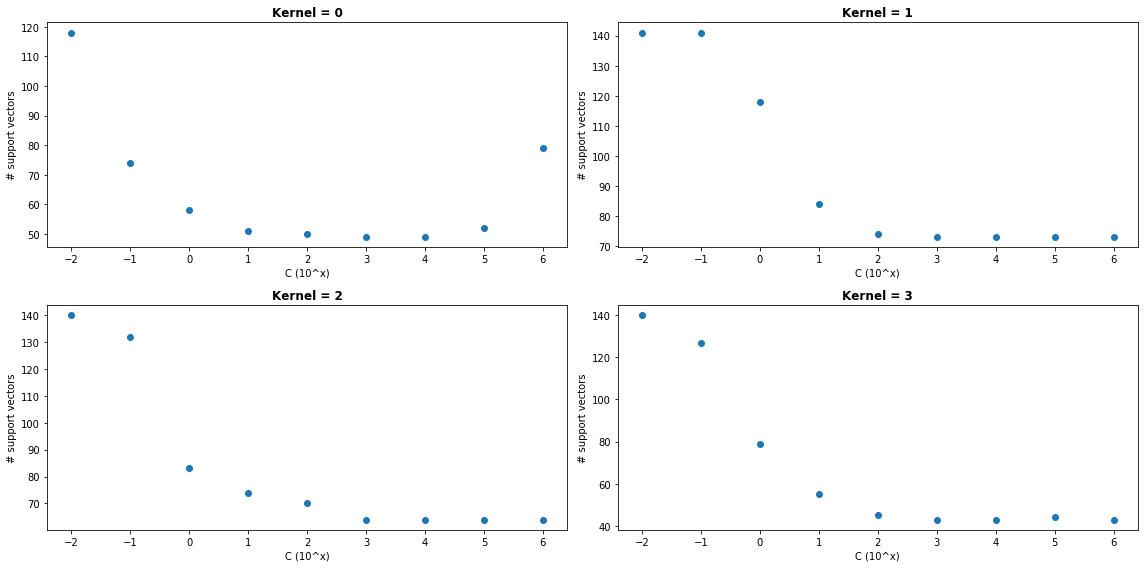

In [9]:
plt.figure(figsize=(16,8))
for i in range(4):
    ax=plt.subplot(2, 2, i+1)
    sub_data = n[np.where(n[:,0] == i)] # i stands for the kernel.
    x = [math.log(y,10) for y in c_vals]
    y = sub_data[:,4] # vectors
    ax.scatter(x, y) 
    ax.set_xlabel('C (10^x)')
    ax.set_ylabel('# support vectors')
    ax.set_title('Kernel = {}'.format(i),fontweight="bold")
plt.tight_layout()
plt.show() 

### Observations

The results are compatible with the theory. As C incerases, the number of support vectors either decreses or stays unchanged except for only one edge case observed when $kernel = 0$ and $c=6$.

## Task 4 - 15 pts

Please investigate the changes in the hyperplane when you remove one of the support vectors, vs., one data point that is not a support vector.

In [10]:
# https://stackoverflow.com/questions/10131385/matlab-libsvm-how-to-find-the-w-coefficients
# TODO

    sv_indices = hard_svm_model.get_sv_indices()\n
    sv_indices = [x - 1 for x in sv_indices]
    num_of_support_vectors =  len(sv_indices)
    
    sv_coefs = hard_svm_model.get_sv_coef()
    sv_coefs = np.array([x[0] for x in sv_coefs]).reshape(num_of_support_vectors,1)



    support_vectors = [train_x[i] for i in sv_indices]
    w = (np.dot(sv_coefs  support_vectors))

    print(w)"

### Bonus Task - 10 pts

Use Python and [CVXOPT](http://cvxopt.org) QP solver to implement the hard margin SVM. 